In [1]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\PandoraRecoFile_1.root")

In [3]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x, z, s=0.5)
                
        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 1000
        #inlier_threshold = 2.0
        
        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model
            
            if plot == True:
                x_inliers = x[best_inliers]
                z_inliers = z[best_inliers]
                plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                plt.plot(x_inliers, m * x_inliers + c)
                plt.xlabel('x')
                plt.ylabel('w')
        
            perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
            num_points = int(0.5 * len(x))
            mean = np.mean(perp_dist[:num_points])
            resis.append(mean)
        else:
            print("No inliers found for a particle")
    
    if plot == True:
        plt.show()
    
    return np.array(resis)

In [4]:
def allresiduals():
    allnumber = []
    for i in np.unique(events.event_number):
        resid = inlierplot(i, False)
        allnumber.append(resid)
    return np.array(allnumber)
    

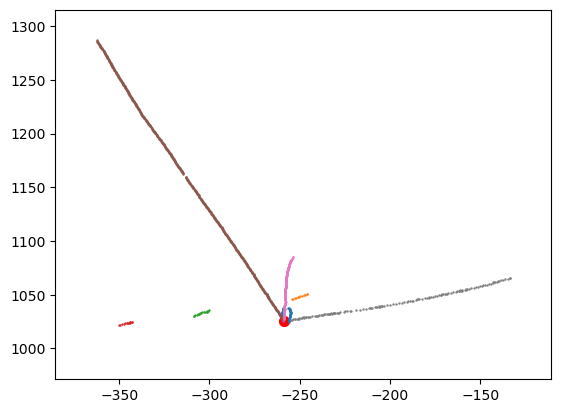

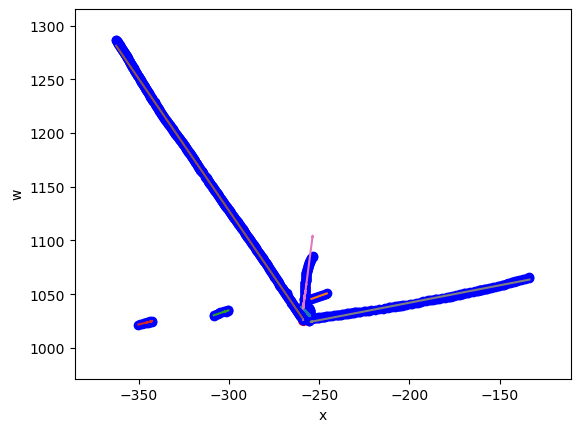

array([1.70001881e+00, 9.38235451e-03, 2.67122272e-01, 1.41800411e-01,
       3.92455200e-04, 2.38269452e-01, 3.69282492e-01, 1.20317294e+00])

In [12]:
inlierplot(26, True)